In [ ]:
import numpy as np
import pylab as plt
from simulate_network import plot_data, run_simulation, evaluate
import pandas as pd
import scipy as sc
%matplotlib inline

In [ ]:
import sys;
!{sys.executable} -m pip install pydmd;
import pydmd;

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pydmd import DMD

We will obtain data from a network of spiking neurons. The data is a LFP-like signal obtained from 8 channels corresponding to different neural populations from which the signal is measured.
The function *run_simulation* takes 5 optional arguments:
* t_sim
  [ms] simulation time (will be the length of the time dimension in ms).
* stim_strength
  [Hz] strength of external stimulation in Hz (if 0 no stimulation is applied).
* stim_start
  [ms] start of the applied external stimulation in ms.
* stim_dur
  [ms] duration of the applied external stimulation in ms.
* population
  *int* 0 to 7. refering to the population that the stimulation will be applied to.

The function returns a numpy array which has a time-series for each of the populations.

In [16]:
#data = run_simulation(t_sim=1000, stim_strength=50, stim_start=500, stim_dur=10, population=0, output='V_m')

In [17]:
data, data_neuron = run_simulation(t_sim=1000, stim_strength=50, stim_start=500, stim_dur=10, population=0, output='V_m')
%store data
%store data_neuron

Run spiking neural network...

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: Aug  9 2022 10:44:45

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

Collect data from file...
	Population 1/8
	Population 2/8
	Population 3/8
	Population 4/8
	Population 5/8
	Population 6/8
	Population 7/8
	Population 8/8


/home/computer_classes/infer_network_from_LFP_project/simulate_network.py:105: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Stored 'data' (ndarray)
Stored 'data_neuron' (ndarray)


In [18]:
def DMD2(data, r):
    """Dynamic Mode Decomposition (DMD) algorithm."""
    
    ## Build data matrices
    X1 = data[:, : -1]
    X2 = data[:, 1 :]
    ## Perform singular value decomposition on X1
    u, s, v = np.linalg.svd(X1, full_matrices = False)
    ## Compute the Koopman matrix
    A_tilde = u[:, : r].conj().T @ X2 @ v[: r, :].conj().T * np.reciprocal(s[: r])
    ## Perform eigenvalue decomposition on A_tilde
    Phi, Q = np.linalg.eig(A_tilde)
    ## Compute the coefficient matrix
    Psi = X2 @ v[: r, :].conj().T @ np.diag(np.reciprocal(s[: r])) @ Q
    A = Psi @ np.diag(Phi) @ np.linalg.pinv(Psi)
    
    return A_tilde, Phi, A

def DMD4cast2(data, r, pred_step):
    N, T = data.shape
    _, _, A = DMD(data, r)
    mat = np.append(data, np.zeros((N, pred_step)), axis = 1)
    for s in range(pred_step):
        mat[:, T + s] = (A @ mat[:, T + s - 1]).real
    return mat[:, - pred_step :]

In [19]:
data_neuron[0].shape

(2068000, 3)

In [20]:
data_neuron

array([array([[ 1.0000e+00,  5.0000e+02, -6.6915e+01],
              [ 2.0000e+00,  5.0000e+02, -6.2364e+01],
              [ 3.0000e+00,  5.0000e+02, -5.8002e+01],
              ...,
              [ 2.0660e+03,  1.4990e+03, -6.3237e+01],
              [ 2.0670e+03,  1.4990e+03, -6.5508e+01],
              [ 2.0680e+03,  1.4990e+03, -5.4157e+01]]),
       array([[2069.   ,  500.   ,  -62.591],
              [2070.   ,  500.   ,  -56.03 ],
              [2071.   ,  500.   ,  -54.783],
              ...,
              [2649.   , 1499.   ,  -56.818],
              [2650.   , 1499.   ,  -60.357],
              [2651.   , 1499.   ,  -53.9  ]]),
       array([[2652.   ,  500.   ,  -56.587],
              [2653.   ,  500.   ,  -55.631],
              [2654.   ,  500.   ,  -55.836],
              ...,
              [4841.   , 1499.   ,  -65.746],
              [4842.   , 1499.   ,  -62.234],
              [4843.   , 1499.   ,  -54.433]]),
       array([[4844.   ,  500.   ,  -57.1  ],
         

In [21]:
data_neuron[0]

array([[ 1.0000e+00,  5.0000e+02, -6.6915e+01],
       [ 2.0000e+00,  5.0000e+02, -6.2364e+01],
       [ 3.0000e+00,  5.0000e+02, -5.8002e+01],
       ...,
       [ 2.0660e+03,  1.4990e+03, -6.3237e+01],
       [ 2.0670e+03,  1.4990e+03, -6.5508e+01],
       [ 2.0680e+03,  1.4990e+03, -5.4157e+01]])

In [22]:
index_list =  []
for i in range(8):
    index_list.append((data_neuron[i].shape[0] / 1000))
          
index_list = [int(x) for x in index_list] 
index_list

[2068, 583, 2192, 548, 485, 106, 1440, 295]

In [23]:
# for each time point, get the voltage values of all neurons
# in a single column

neuron_data = []
for t in range(1000):
    pop_list = []
    for i in range(8):
        pop_vs = data_neuron[i][:, 2][index_list[i]*t: index_list[i]*(t+1)]
        pop_list.append(pop_vs)
    
    pop_flat_list = [item for sublist in pop_list for item in sublist]
    neuron_data.append(pop_flat_list)


In [24]:
neuron_data_arr = np.array(neuron_data)
neuron_data_arr.shape

(1000, 7717)

In [25]:
X1_n = neuron_data_arr[:, :-1]
X2_n = neuron_data_arr[:, 1:]
X_n = X1_n + X2_n

dmd_n = DMD(svd_rank=4)
dmd_n.fit(X_n)

In [26]:
A_tilde_n, Phi_n, A_n = DMD2(neuron_data_arr.T, 2)
print(Phi_n)

[0.99999557 0.97970411]


In [27]:
Phi_n

array([0.99999557, 0.97970411])

In [28]:
A_n.shape

(7717, 7717)

In [29]:
A_tilde_n

array([[9.99993065e-01, 6.08598947e-02],
       [8.35451589e-07, 9.79706616e-01]])

In [30]:
# import scipy as sc
# A_cont_n = np.real(sc.linalg.logm(np.real(A_n)))
# #A_cont = np.real(A)
# A_cont_scaled_n = A_cont_n / np.linalg.norm(A_cont_n)

# #sns.heatmap(A_cont_scaled)
# plt.figure()
# plt.imshow(A_cont_scaled_n, cmap='bwr', vmin=-1, vmax=1)
# plt.colorbar()

In [31]:
# a 2D array with linearly increasing values on the diagonal
A_cont_n = np.real(sc.linalg.logm(np.real(A_n)))
# #A_cont = np.real(A)
A_cont_scaled_n = A_cont_n / np.linalg.norm(A_cont_n)

KeyboardInterrupt: 

In [ ]:
plt.matshow(A_cont_scaled)

plt.show()

In [ ]:
len(pop_list)

8

In [ ]:
data_full_df = pd.DataFrame(data_full[1])

In [ ]:
col1 = set(data_full_df.iloc[:, 0])

In [ ]:
col1

In [ ]:
len(col1)

In [ ]:
data_lpf = data[0]

In [ ]:
np.savetxt('data_lpf.csv', data_lpf, delimiter=',')

In [ ]:
len(data[0])

In [ ]:
len(data)

In [ ]:
for i in range(

In [ ]:
# import csv

# #list_of_tuples = [(1, 'one'), (2, 'two'), (3, 'three')]

# # ✅ Write list of tuples to text file (formatted string literal)
# with open('lpf_data.txt', 'w', encoding='utf-8') as f:
#     f.write('\n'.join(f'{tup[0]} {tup[1]}' for tup in list_of_tuples))

In [ ]:
print(data[1])
data = data[0]
data.shape

In [ ]:
data = data_lpf

In [ ]:
data.T.shape

In [ ]:
# plt.plot(data.T, label=np.arange(8))
# plt.legend()
# plt.show()

In [ ]:
plot_data(data)

In [ ]:
# for i in range(8):
#     plt.figure()
#     plt.plot(data.T[:, i])
#     plt.title(i)

In [ ]:
data_df = pd.DataFrame(data)

In [ ]:
data_df.head()

In [ ]:
col1 = set(data_df.iloc[:, 0])

In [ ]:
#col1

In [ ]:
len(col1)

In [ ]:
data_df.shape

In [ ]:
data_df_T = data_df.T

In [ ]:
data_df_T.head()

In [ ]:
data_df_T.describe()

In [ ]:
len(data[0])

In [ ]:
# Koopman matrix, eigenvalues, and coefficient matrix.
A_tilde, Phi, A = DMD2(data, 2)
print(Phi)

[0.99999369 0.88899969]


In [ ]:
# Predicting next 2 time steps for example
#mat_hat = DMD4cast(data, 2, 2)
#print(mat_hat)

In [ ]:
import matplotlib.pyplot as plt

x= [ele.real for ele in Phi]
y= [ele.imag for ele in Phi]

plt.scatter(x,y)
plt.show

<function matplotlib.pyplot.show(*, block=None)>

In [ ]:
temp = [ele.real for ele in Phi]

In [ ]:
temp

[0.9999936888808555, 0.8889996922898752]

In [ ]:
!{sys.executable} -m pip install seaborn;

In [ ]:
X1 = data[:, : -1]
X2 = data[:, 1 :]
X= X1 + X2 

dmd = DMD(svd_rank=4)
dmd.fit(X)

In [ ]:
for eig in dmd.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmd.plot_eigs(show_axes=True, show_unit_circle=True)

Eigenvalue (0.999996577444333+0j): distance from unit circle 6.84509962012303e-06
Eigenvalue (0.9246097887485765+0.02418487418450824j): distance from unit circle 0.14451183041099236
Eigenvalue (0.9246097887485765-0.02418487418450824j): distance from unit circle 0.14451183041099236
Eigenvalue (0.8890908558999029+0j): distance from unit circle 0.20951744995517807


In [ ]:
x= np.linspace(0, 7, 8)
t = np.linspace(0, 996, 997)

for mode in dmd.modes.T:
    plt.plot(x, mode.real)
    plt.title('Modes')
plt.show()

for dynamic in dmd.dynamics:
    plt.plot(t, dynamic.real)
    plt.title('Dynamics')
plt.show()

In [ ]:
#np.linspace(dynamic.real.shape)

In [ ]:
temp = dynamic.real
temp.shape

(997,)

In [ ]:
x.shape

(8,)

In [ ]:
t.shape

(997,)

In [ ]:
xgrid, tgrid = np.meshgrid(x, t)

In [ ]:
A_tilde.shape

(2, 2)

In [ ]:
print(A_tilde)

[[ 9.99997030e-01 -6.77265887e-02]
 [ 5.47518534e-06  8.88996352e-01]]


In [ ]:
import seaborn as sns
sns.heatmap(A_tilde)

<AxesSubplot:title={'center':'Dynamics'}>

In [ ]:
sns.heatmap(dmd.atilde)

<AxesSubplot:title={'center':'Dynamics'}>

In [ ]:
recon_error = abs(dmd.snapshots - dmd.reconstructed_data)/dmd.snapshots

In [ ]:
recon_error

array([[-3.51666778e-03, -1.53289751e-02, -2.05704767e-02, ...,
        -3.69575622e-02, -2.97576467e-02, -2.20111961e-02],
       [-7.83732940e-03, -7.47693992e-04, -4.79763808e-03, ...,
        -3.63779900e-02, -3.29132285e-02, -2.72973067e-02],
       [-9.61339208e-04, -7.37694866e-04, -2.61634864e-03, ...,
        -6.26384440e-03, -6.81525558e-03, -9.63594312e-03],
       ...,
       [-5.62734139e-03, -1.73449805e-03, -3.39987072e-03, ...,
        -1.67059337e-02, -1.03610961e-02, -5.57715475e-03],
       [-1.52266103e-03, -3.65937761e-03, -5.06890485e-05, ...,
        -8.02624548e-03, -1.80681651e-03, -6.74446762e-03],
       [-1.86506341e-03, -2.65978334e-03, -7.47823036e-03, ...,
        -6.18401297e-03, -1.26817441e-04, -2.53738079e-03]])

In [ ]:
sns.heatmap(recon_error)

<AxesSubplot:title={'center':'Dynamics'}>

<AxesSubplot:>

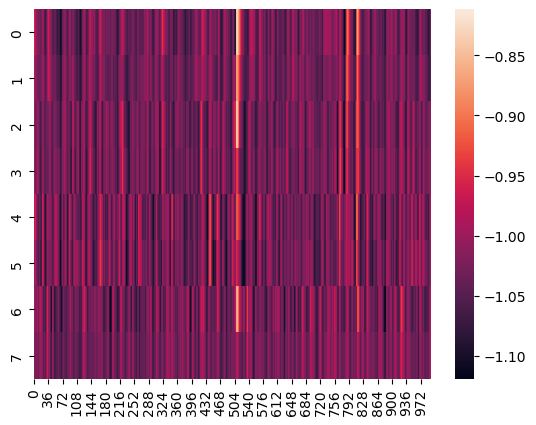

In [ ]:
#plt.pcolor(xgrid, tgrid, (X-dmd.reconstructed_data.T).real)
#fig = plt.colorbar()
recon_error2 = abs(data[:, 1:] - dmd.reconstructed_data)/data[:, 1:]
sns.heatmap(recon_error2)

In [ ]:
#plt.pcolor(xgrid, tgrid, (data-dmd.reconstructed_data.T).real)
#fig = plt.colorbar()

In [ ]:
x

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [ ]:
xgrid.shape

(997, 8)

In [ ]:
tgrid.shape

(997, 8)

In [ ]:
data.shape

(8, 998)

In [ ]:
xgrid2, tgrid2 = np.meshgrid(x, np.linspace(0, 997, 998))

In [ ]:
xgrid2.shape

(998, 8)

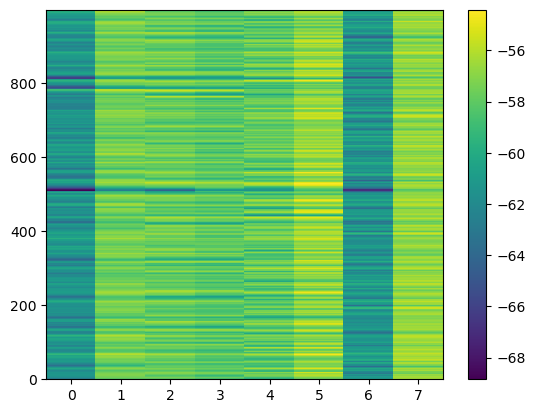

In [ ]:
# Plotting original data in colormap
#plt.style.use('seaborn-dark-palette')
plt.pcolor(xgrid2, tgrid2, data.real.T)   
    
plt.colorbar()
plt.show()

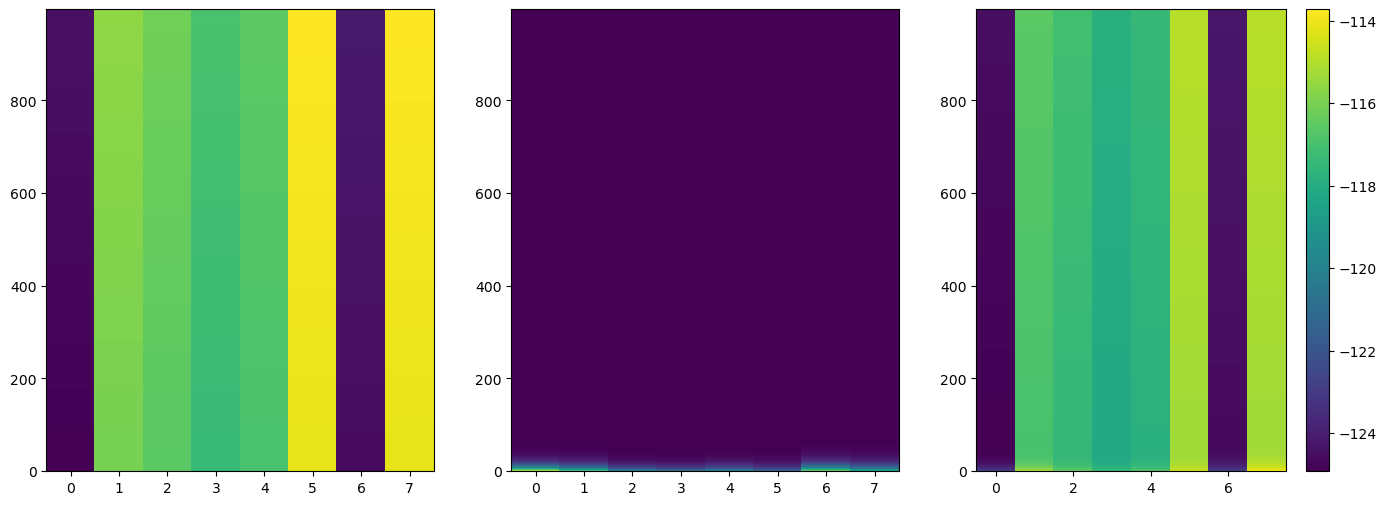

In [ ]:
# Plotting d
fig = plt.figure(figsize=(17,6))

for n, mode, dynamic in zip(range(131, 133), dmd.modes.T, dmd.dynamics):
    plt.subplot(n)
    plt.pcolor(xgrid, tgrid, (mode.reshape(-1, 1).dot(dynamic.reshape(1, -1))).real.T)
    
plt.subplot(133)
plt.pcolor(xgrid, tgrid, dmd.reconstructed_data.T.real)
plt.colorbar()

plt.show()

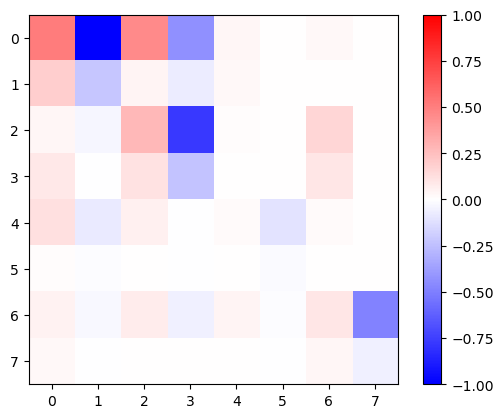

In [ ]:
# Ground truth connections
# conn_probs = np.array(
#             [[0.1009, 0.1689, 0.0437, 0.0818, 0.0323, 0., 0.0076, 0.],
#              [0.1346, 0.1371, 0.0316, 0.0515, 0.0755, 0., 0.0042, 0.],
#              [0.0077, 0.0059, 0.0497, 0.135, 0.0067, 0.0003, 0.0453, 0.],
#              [0.0691, 0.0029, 0.0794, 0.1597, 0.0033, 0., 0.1057, 0.],
#              [0.1004, 0.0622, 0.0505, 0.0057, 0.0831, 0.3726, 0.0204, 0.],
#              [0.0548, 0.0269, 0.0257, 0.0022, 0.06, 0.3158, 0.0086, 0.],
#              [0.0156, 0.0066, 0.0211, 0.0166, 0.0572, 0.0197, 0.0396, 0.2252],
#              [0.0364, 0.001, 0.0034, 0.0005, 0.0277, 0.008, 0.0658, 0.1443]])


cons = [[0.51,  -1.000, 0.454, -0.433, 0.037, -0.000, 0.025, -0.000],
         [0.195, -0.225, 0.046, -0.076, 0.025, -0.000, 0.004, -0.000],
         [0.039, -0.034, 0.274, -0.780, 0.008, -0.000, 0.164, -0.000],
         [0.091, -0.004, 0.111, -0.234, 0.001, -0.000, 0.099, -0.000],
         [0.119, -0.081, 0.062, -0.007, 0.023, -0.108, 0.016, -0.000],
         [0.014, -0.008, 0.007, -0.001, 0.004, -0.019, 0.001, -0.000],
         [0.052, -0.025, 0.075, -0.059, 0.046, -0.014, 0.094, -0.485],
         [0.025, -0.001, 0.002, -0.000, 0.004, -0.001, 0.032, -0.061]]

plt.figure()
plt.imshow(cons, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()

#sns.heatmap(cons)

/opt/conda/envs/nest_env/lib/python3.10/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning:The logm input matrix is exactly singular.


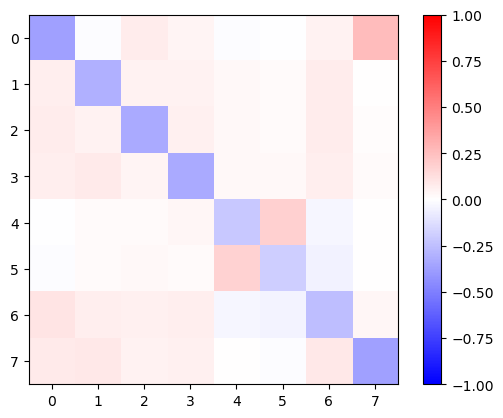

In [ ]:
import scipy as sc
A_cont = np.real(sc.linalg.logm(np.real(A)))
#A_cont = np.real(A)
A_cont_scaled = A_cont / np.linalg.norm(A_cont)

#sns.heatmap(A_cont_scaled)
plt.figure()
plt.imshow(A_cont_scaled, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()

In [ ]:
from simulate_network import evaluate
evaluate(A_cont_scaled)

0.1682016634223366

In [49]:
scores = []

for i in range(1000):
    random_vals = (np.random.rand(8,8) - 0.5) * 2
    scores.append(evaluate(random_vals))
    
np.mean(scores)
#plt.figure()
#plt.imshow(random_vals, cmap='bwr', vmin=-1, vmax=1)
#plt.colorbar()

0.3887455039560361

In [50]:
evaluate(np.zeros([8,8]))

1.0757362968750002

In [45]:
evaluate(random_vals)

0.32752121207359736

In [35]:
# looping over nr. of modes to find the one giving the lowest MSE

errors = []
for i in range(1,9):
    A_tilde, Phi, A = DMD2(data, i)
    A_cont = np.real(sc.linalg.logm(np.real(A)))
    A_cont_scaled = A_cont / np.linalg.norm(A_cont)
    errors.append(evaluate(A_cont_scaled))

errors

[0.19169112074595834,
 0.1682016634223366,
 0.17766301708066598,
 0.21669847810375875,
 0.23096935142565705,
 0.24899269729505635,
 0.2850575515306071,
 0.2002583416229522]

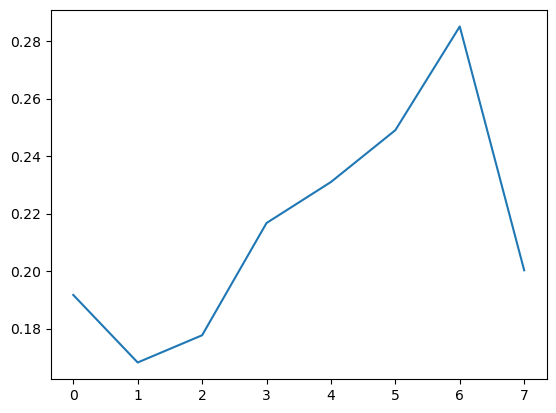

In [ ]:
plt.plot(errors)

<AxesSubplot:>

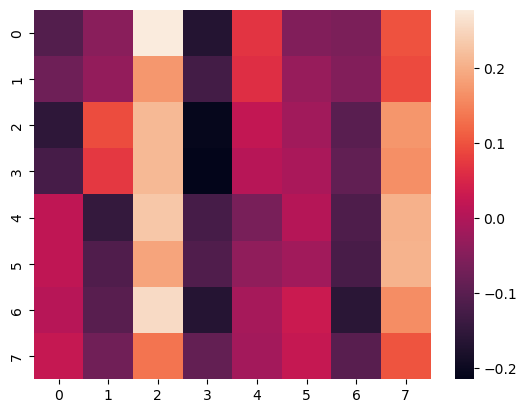

In [ ]:
sns.heatmap(A_cont_scaled)

In [ ]:
#!{sys.executable} -m pip install pyyeti 
#import pyyeti as pyyeti;

In [ ]:
#A_disc = pyyeti.d2c(A)

In [ ]:
#pyyeti.ssmodel.SSModel.d2c(A)

In [ ]:
#data_long = run_simulation(t_sim=12000, stim_strength=50, stim_start=500, stim_dur=10, population=0, output='V_m')


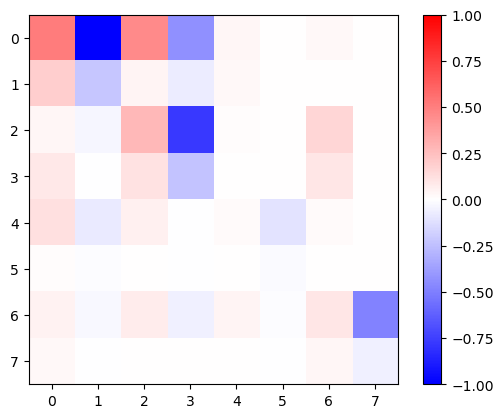

In [ ]:
plt.figure()
plt.imshow(cons, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()

In [ ]:
# resampling data at every 12th timestep
data_resampled = []
for i in range(0, 1000, 12):
    data_resampled.append(data_lpf[:, i])

data_resampled = np.array(data_resampled).T

NameError: name 'data_lpf' is not defined

In [ ]:
data_resampled.shape

In [ ]:
import scipy as sc

In [ ]:
# Koopman matrix, eigenvalues, and coefficient matrix.
A_tilde_r, Phi_r, A_r = DMD2(data_resampled, 8)

In [ ]:
plt.figure()
plt.imshow(cons, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()

In [ ]:
A_cont = np.real(sc.linalg.logm(np.real(A_r)))
#A_cont = np.real(A)
A_cont_scaled = A_cont / np.linalg.norm(A_cont)

#sns.heatmap(A_cont_scaled)
plt.figure()
plt.imshow(A_cont_scaled, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [ ]:
A_tilde_cont = np.real(sc.linalg.logm(np.real(A_tilde_r)))
#A_cont = np.real(A)
A_tilde_cont_scaled = A_tilde_cont / np.linalg.norm(A_tilde_cont)

#sns.heatmap(A_cont_scaled)
plt.figure()
plt.imshow(A_tilde_cont_scaled, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [ ]:
evaluate(A_tilde_cont_scaled)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

ax1, ax2 = axes

im1 = ax1.matshow(cons, cmap='bwr', vmin=-1, vmax=1)
im2 = ax2.matshow(A_cont_scaled, cmap='bwr', vmin=-1, vmax=1)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

#plt.imshow(im1, cmap='bwr', vmin=-1, vmax=1)

#fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

In [ ]:
evaluate(A_cont_scaled)

In [ ]:
sns.heatmap(A_tilde_r)

In [ ]:
evaluate(A_tilde_r)

In [ ]:
#evaluate(np.zeros([8,8]) + np.ones([8,8])*1e-06)